In [ ]:
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

My data set is x-rays of healthy and pneumonia lungs.
I want to create CNN to extract relevant features from the X-Ray images and classify them.

Data consists of 3 folders - train, test, val. Train & test are used for modeling, validation will be used to check performance of model.

Create dataframes so we can visualize distribution of cases in each set



In [ ]:
import glob
import random as rn
import pandas as pd

path = '/content/drive/MyDrive/chest_xray/'

# Definiowanie ścieżek
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'

# Znajdowanie plików - pliki mają rozszerzenie jpeg
train_normal_cases = glob.glob(train_normal_dir + '*.jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*.jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*.jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*.jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*.jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*.jpeg')

# Zamiana '\\' na '/' w ścieżkach - to może być zbędny krok
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]

# Tworzenie list dla przypadków treningowych, testowych i walidacyjnych, tworzenie również etykiet
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 'NORMAL'])

for x in train_pneu_cases:
    train_list.append([x, 'PNEUMONIA'])

for x in test_normal_cases:
    test_list.append([x, 'NORMAL'])

for x in test_pneu_cases:
    test_list.append([x, 'PNEUMONIA'])

for x in val_normal_cases:
    val_list.append([x, 'NORMAL'])

for x in val_pneu_cases:
    val_list.append([x, 'PNEUMONIA'])

# Losowe wymieszanie danych, ponieważ zostały załadowane w kolejności: najpierw przypadki zdrowe, a następnie przypadki z zapaleniem płuc
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)

# Tworzenie obiektów DataFrame
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])



<h2> Visualize distribution of cases </h2>

Visualize the class distribution (normal vs. pneumonia) in the training, test and validation data. **This visualization helps understand the proportions of the data for each class and assess whether there is any unbalanced distribution.**

And why i did it, because i read on kaggle that this data set is unbalanced and that can influence on result. For example: unbalanced distribution of classes can lead to improper training of the model, which may focus on predicting the dominant class and ignore the smaller class and incorrectly evaluating the model can result in misleading information about its performance.

This code uses matplotlib along with seaborn to generate plots counting the number of images for each class.


0-normal

1-pneumonia

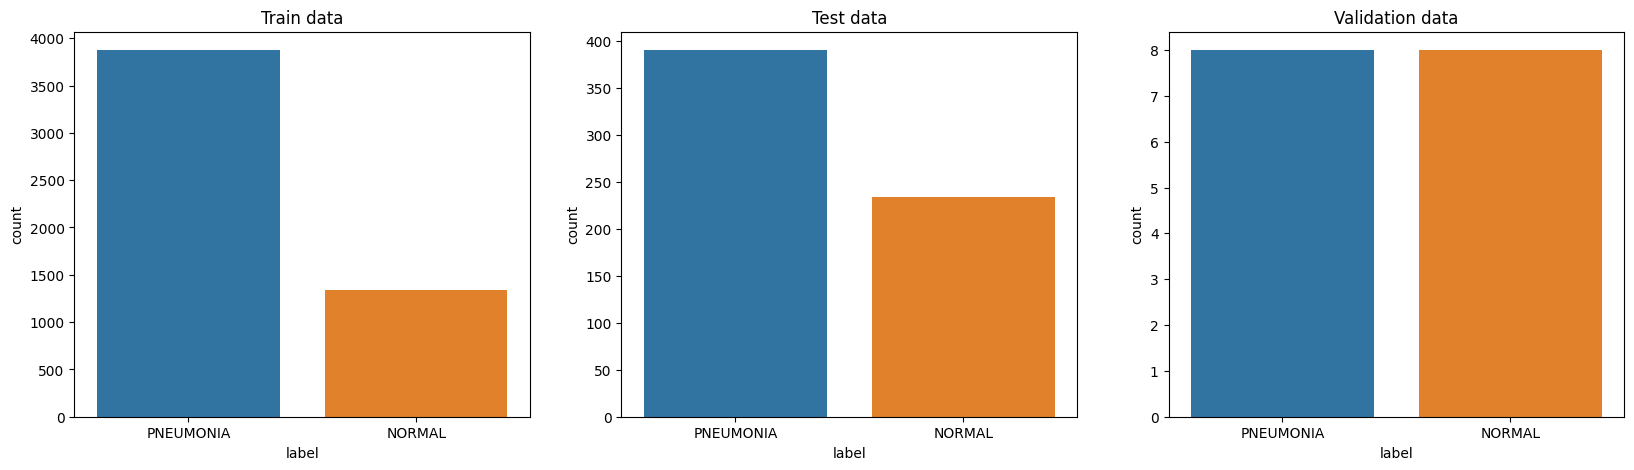

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.countplot(data=train_df, x='label')
plt.title('Train data')

plt.subplot(1, 3, 2)
sns.countplot(data=test_df, x='label')
plt.title('Test data')

plt.subplot(1, 3, 3)
sns.countplot(data=val_df, x='label')
plt.title('Validation data')

plt.show()


Here i just want to show few cases of pneumonia and few cases of healthy people. For uninterested person it may not be easy to identify pneumonia on image. You will also notice that images does not have same dimension and must be rescaled to same width & height.

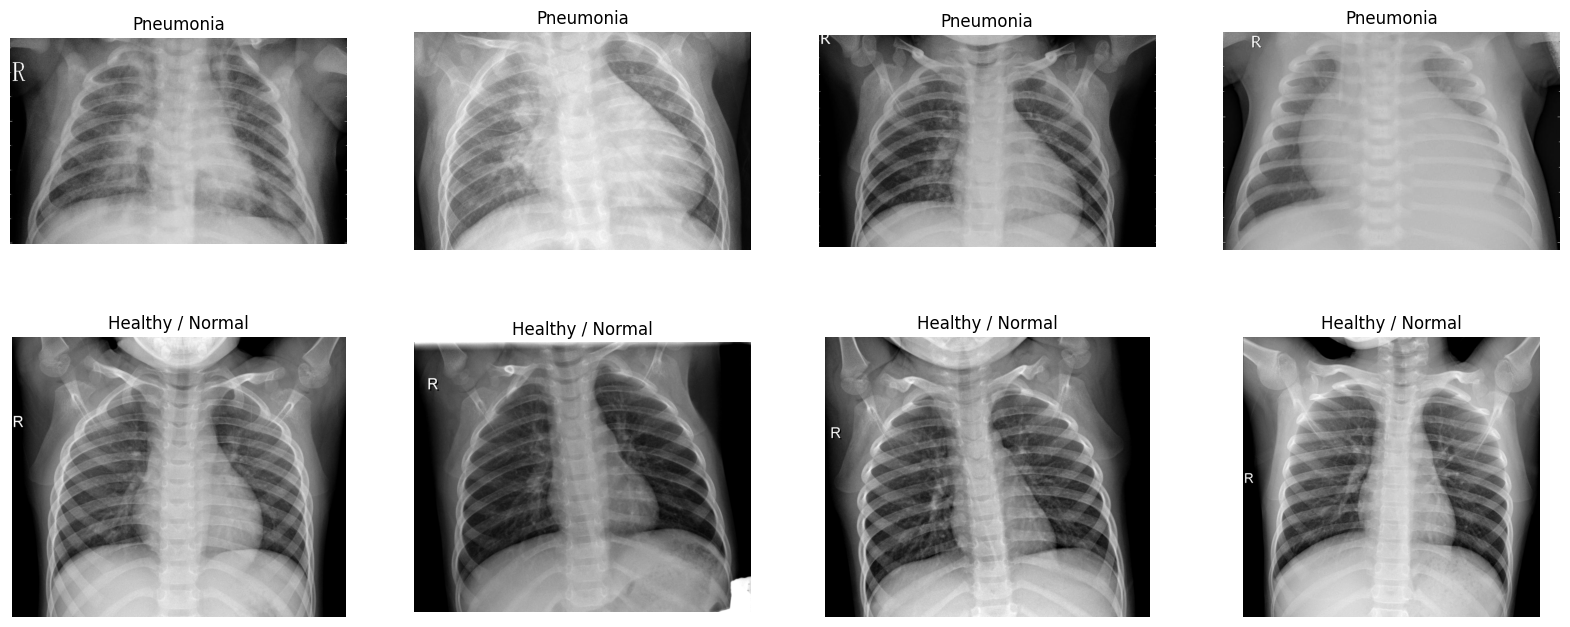

In [ ]:
plt.figure(figsize=(20, 8))
for i, img_path in enumerate(train_df[train_df['label'] == 'PNEUMONIA'].iloc[:4]['image']):
    plt.subplot(2, 4, i + 1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')

for i, img_path in enumerate(train_df[train_df['label'] == 'NORMAL'].iloc[:4]['image']):
    plt.subplot(2, 4, 4 + i + 1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Healthy / Normal')

plt.show()


<h2> Data preprocessing </h2>

Define two function:

-**process_data** - load image, resize it, convert to grayscale, normalize and reshape to dimension required for tensorflow

-**compose_dataset** - loop through images, generating 2 numpy arrays. First contains image itself as matrix, second contains label

i did this because Images have different site and can have one or 3 color channels.

The **process_data** function takes the path of the image as an argument and performs the following operations on the image:

1. Loads the image using- cv2.imread.
2. Resizes the image to 196x196 pixels with cv2.resize.
3. Converts the image to shades of gray using cv2.cvtColor.
4. Normalizes pixel values to a range of 0 to 1 by dividing by 255.0.
5. Reshapes the image to (196, 196, 1) with np.reshape.
6. The function returns the processed image.

The **compose_dataset** function takes a dataframe (df) that contains the image paths and their corresponding labels. It iterates over the rows of the dataframe and does the following for each image:

1. Calls the process_data function to process the image.
2. Adds the processed image to the data list.
3. Adds the corresponding label to the labels list.
4. function returns data and labels as numpy arrays.

In [ ]:
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (196, 196))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (196,196,1))

    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)

    return np.array(data), np.array(labels)

<h2> Data augumentation </h2>

It takes each image and modify it slightly so simply said in each epoch, different image (generated from same) is sent to model for training.

WHY I MAKE DATA AUGUEMNTATION

Image augmentation is a popular machine learning technique that creates new examples of training data by applying random transformations to existing images.

The ImageDataGenerator is used to generate new variations of the training data by applying various transformations such as rotation, zooming, shifting and horizontal/vertical reflections. These transformations introduce diversity in the training data, which can help increase the model's generalizability.


In [ ]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 196, 196, 1), Labels shape: (5216,)
Test data shape: (624, 196, 196, 1), Labels shape: (624,)
Validation data shape: (16, 196, 196, 1), Labels shape: (16,)


In [ ]:
# define generator
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)

<h2> Data Labeling and Categorical Representation </h2>
Such transformation enables a better understanfinf of the structure of the classificatio problem by the model and facilitates the use of appropriate loss fucntions and performance evaluation metrics.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)
y_val_categorical = to_categorical(y_val_encoded)


# Modeling

<h2> Model 1 </h2>

This models serves as the foundation for the rest of the models and cosists of a Sequentia model. Include:
- 4 convolutional layers with maxpooling
-Flattering layer
-2 Dense layer, with dropout

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(7, 7), padding='same', activation='relu', input_shape=(196, 196, 1)))
model.add(Conv2D(filters=16, kernel_size=(7, 7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))


model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))


model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

learning_rate = 0.0001
decay_rate = learning_rate / 100  # Set your desired decay rate

optimizer = Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps=1, decay_rate=decay_rate))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)
y_val_categorical = to_categorical(y_val_encoded)

callback = EarlyStopping(monitor='loss', patience=6)
history = model.fit(datagen.flow(X_train, y_train_categorical, batch_size=4), validation_data=(X_test, y_test_categorical), epochs=100, verbose=1, callbacks=[callback], class_weight={0: 6.0, 1: 0.5})



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h2> Charts </h2>

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()


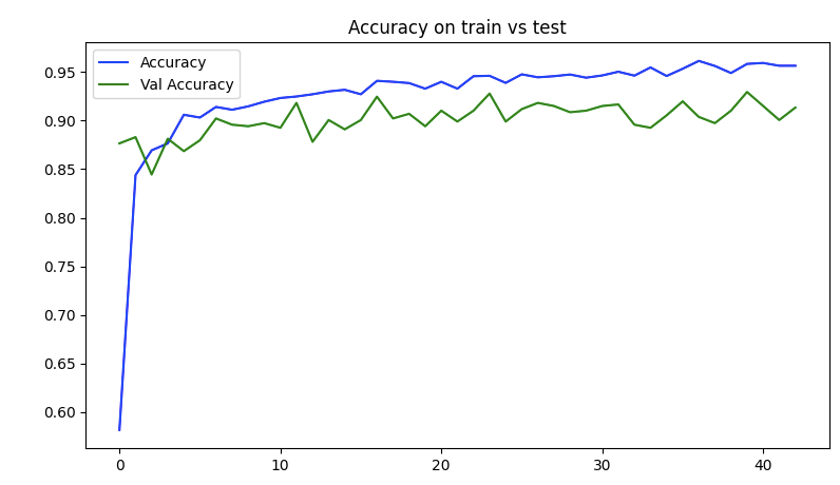

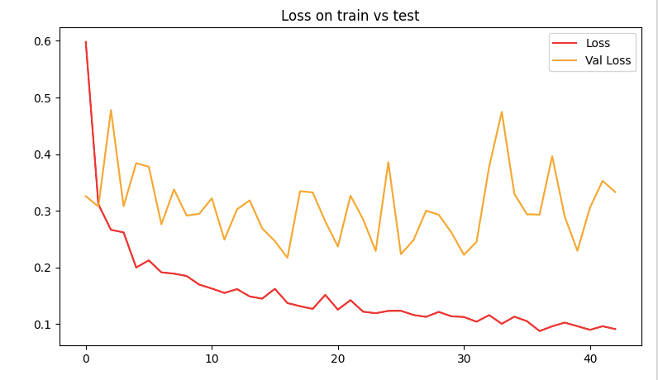

In [ ]:
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)


<h2> Confusion matrix </h2>

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

conf_m = confusion_matrix(y_test_categorical.argmax(axis=1), y_test_hat)
clas_r = classification_report(y_test_categorical.argmax(axis=1), y_test_hat)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True, xticklabels=['H', 'P'], yticklabels=['H', 'P'], cbar=False, cmap='Blues', linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top')
plt.title('Confusion matrix - test data\n(H - healthy/normal, P - pneumonia)')
plt.show()

# print classification report
print('Classification report on test data')
print(clas_r)


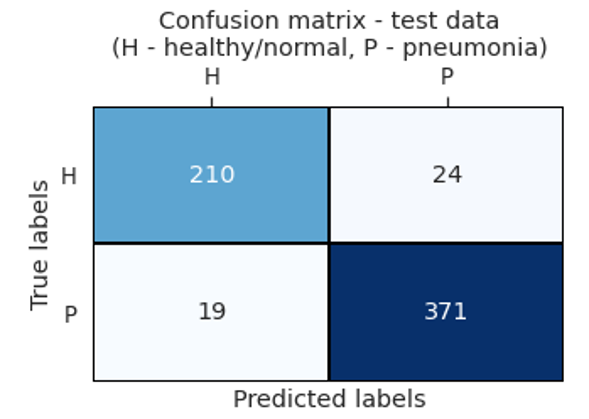

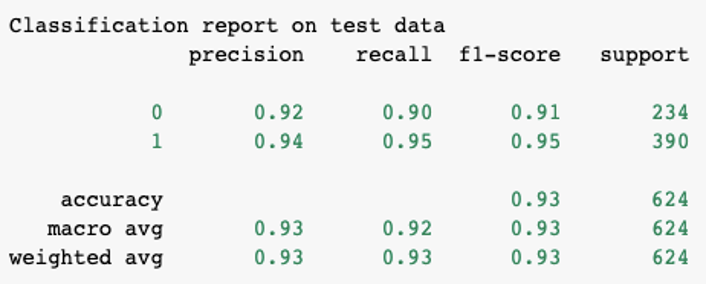

In [ ]:
y_val_hat = model.predict(X_val, batch_size=4)
y_val_hat = np.argmax(y_val_hat, axis=1)


<h2> Classifitacion </h2>

In [ ]:
plt.figure(figsize=(20,15))
for i,x in enumerate(X_val):
    plt.subplot(4,4,i+1)
    plt.imshow(x.reshape(196, 196), cmap='gray')
    plt.axis('off')
    plt.title('Predicted: {}, Real: {}'.format(y_val_hat[i], y_val[i]))

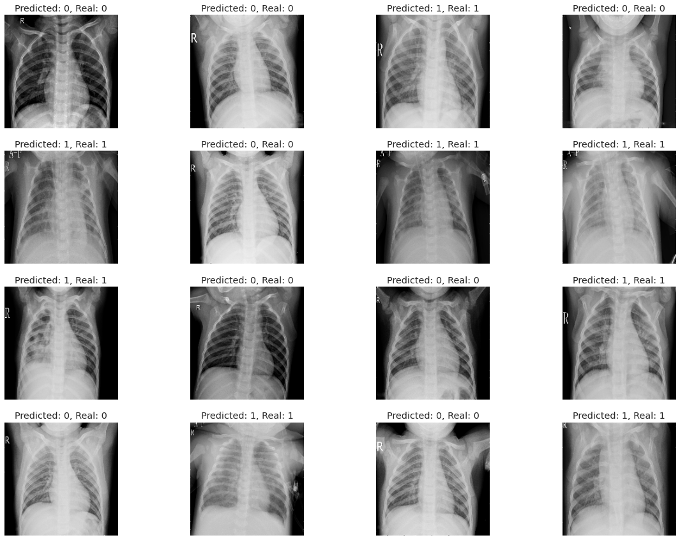

<h2> Model 2 </h2>

Change:

*   decreased value of filter
*   decreased value of dense layer



In [ ]:
model2 = Sequential()
model2.add(Conv2D(filters=16, kernel_size=(7, 7), padding='same', activation='relu', input_shape=(196, 196, 1)))
model2.add(Conv2D(filters=16, kernel_size=(7, 7), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(3, 3)))


model2.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'))
model2.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(3, 3)))


model2.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'))
model2.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Flatten())

model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(2, activation='softmax'))

learning_rate = 0.0001
decay_rate = learning_rate / 100  # Set your desired decay rate

optimizer = Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps=1, decay_rate=decay_rate))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)
y_val_categorical = to_categorical(y_val_encoded)

callback = EarlyStopping(monitor='loss', patience=6)
history = model.fit(datagen.flow(X_train, y_train_categorical, batch_size=4), validation_data=(X_test, y_test_categorical), epochs=100, verbose=1, callbacks=[callback], class_weight={0: 6.0, 1: 0.5})



<h2> Charts </h2>



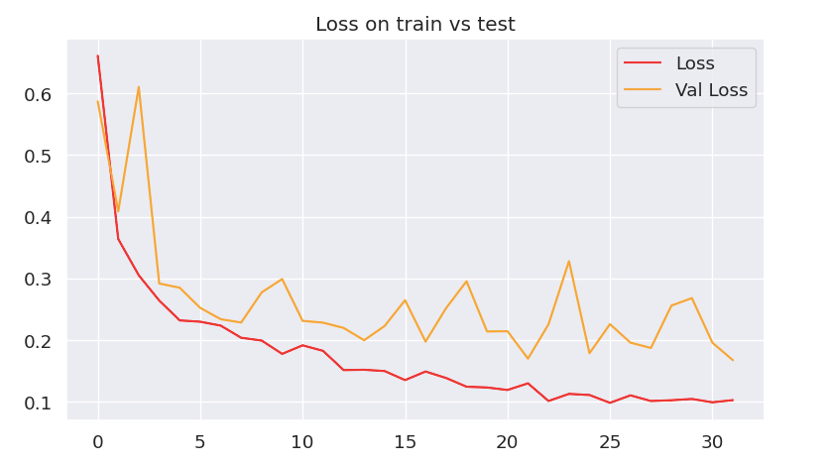

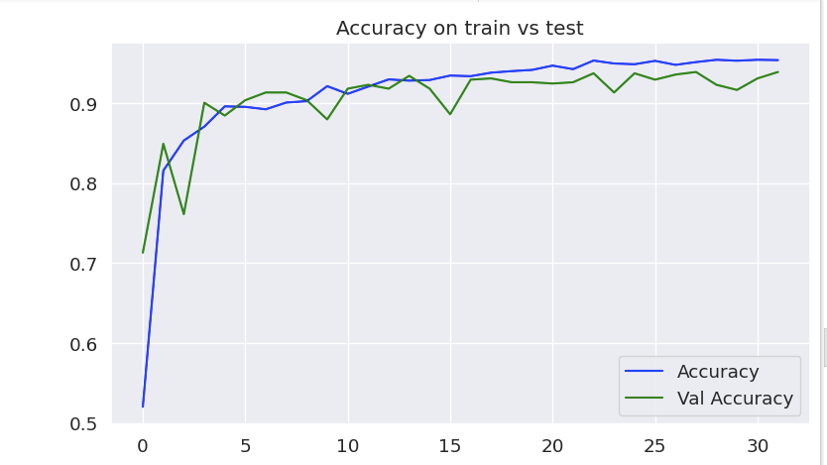

<h2> Confustion matrix </h2>

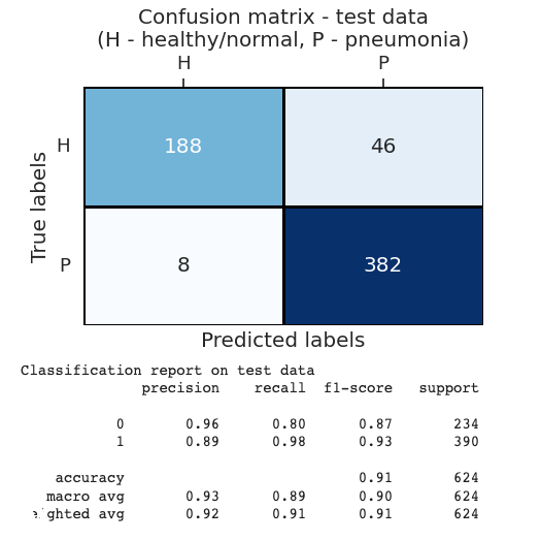

<h2> Classification </h2>

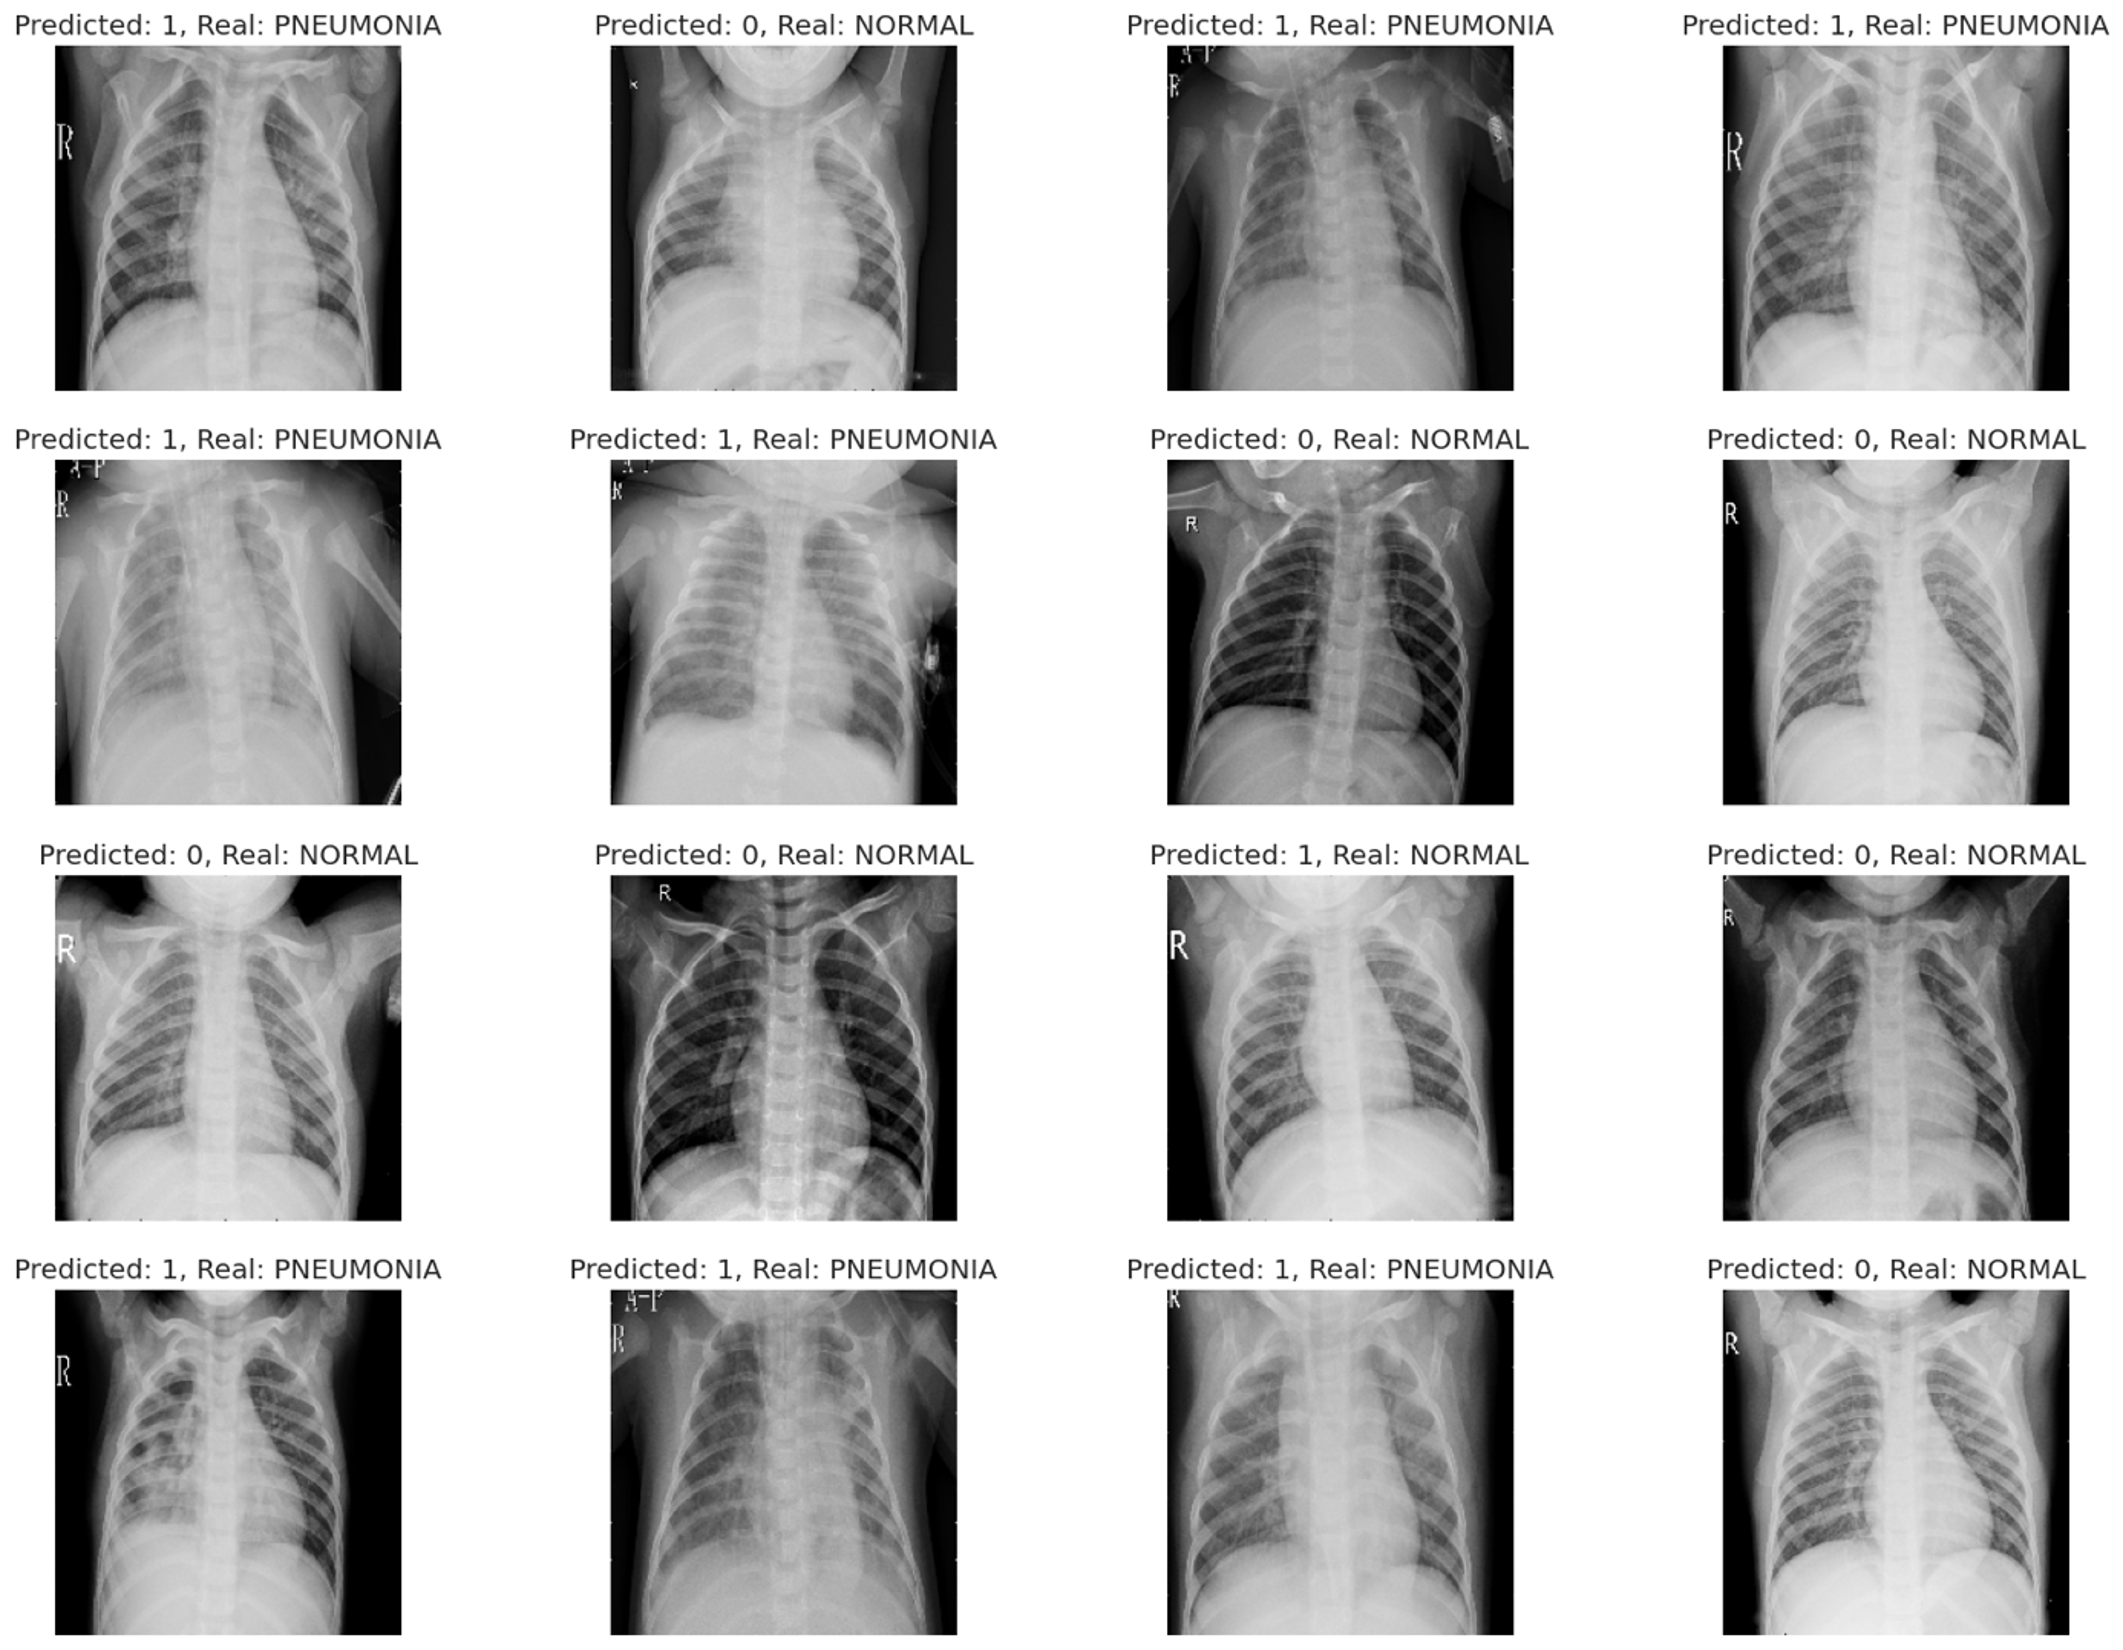

<h2> Model 3 </h2>

Change:


*   add BatchNormalization
*   change dense layer



In [ ]:


model3 = Sequential()
model3.add(Conv2D(filters=16, kernel_size=(7, 7), padding='same', activation='relu', input_shape=(196, 196, 1)))
model3.add(Conv2D(filters=16, kernel_size=(7, 7), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(3, 3)))
model3.add(BatchNormalization())

model3.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'))
model3.add(Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(3, 3)))
model3.add(BatchNormalization())

model3.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'))
model3.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())

model3.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model3.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())

model3.add(Flatten())

model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(2, activation='softmax'))

learning_rate = 0.0001
decay_rate = learning_rate / 100  # Set your desired decay rate

optimizer = Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps=1, decay_rate=decay_rate))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)
y_val_categorical = to_categorical(y_val_encoded)

callback = EarlyStopping(monitor='loss', patience=6)
history = model3.fit(datagen.flow(X_train, y_train_categorical, batch_size=4), validation_data=(X_test, y_test_categorical), epochs=100, verbose=1, callbacks=[callback], class_weight={0: 6.0, 1: 0.5})



<h2> Charts </h2>

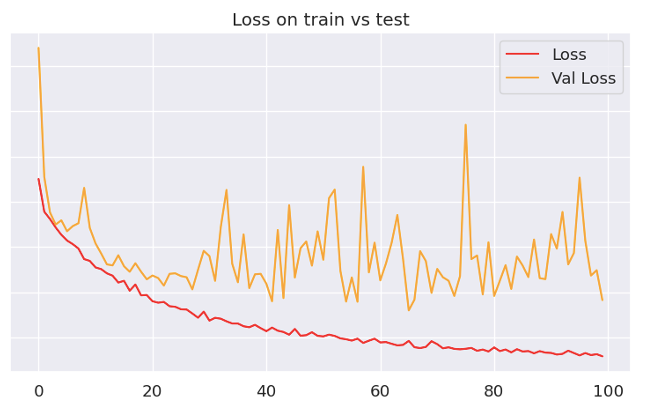

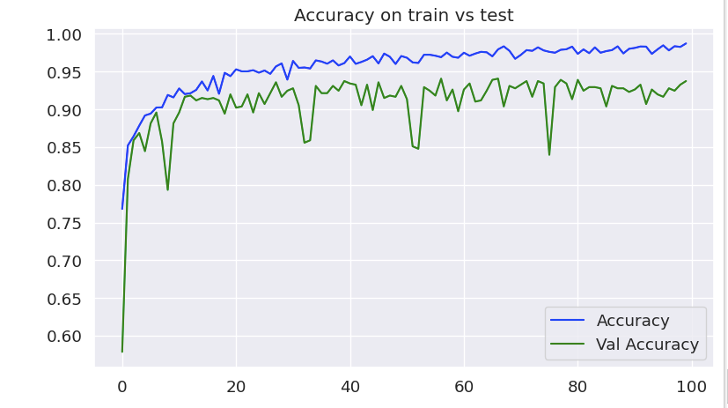

<h2> Confusion matrix </h2>

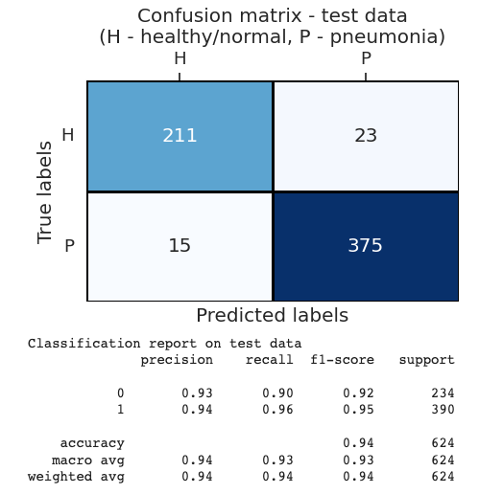

<h2> Classification </h2>

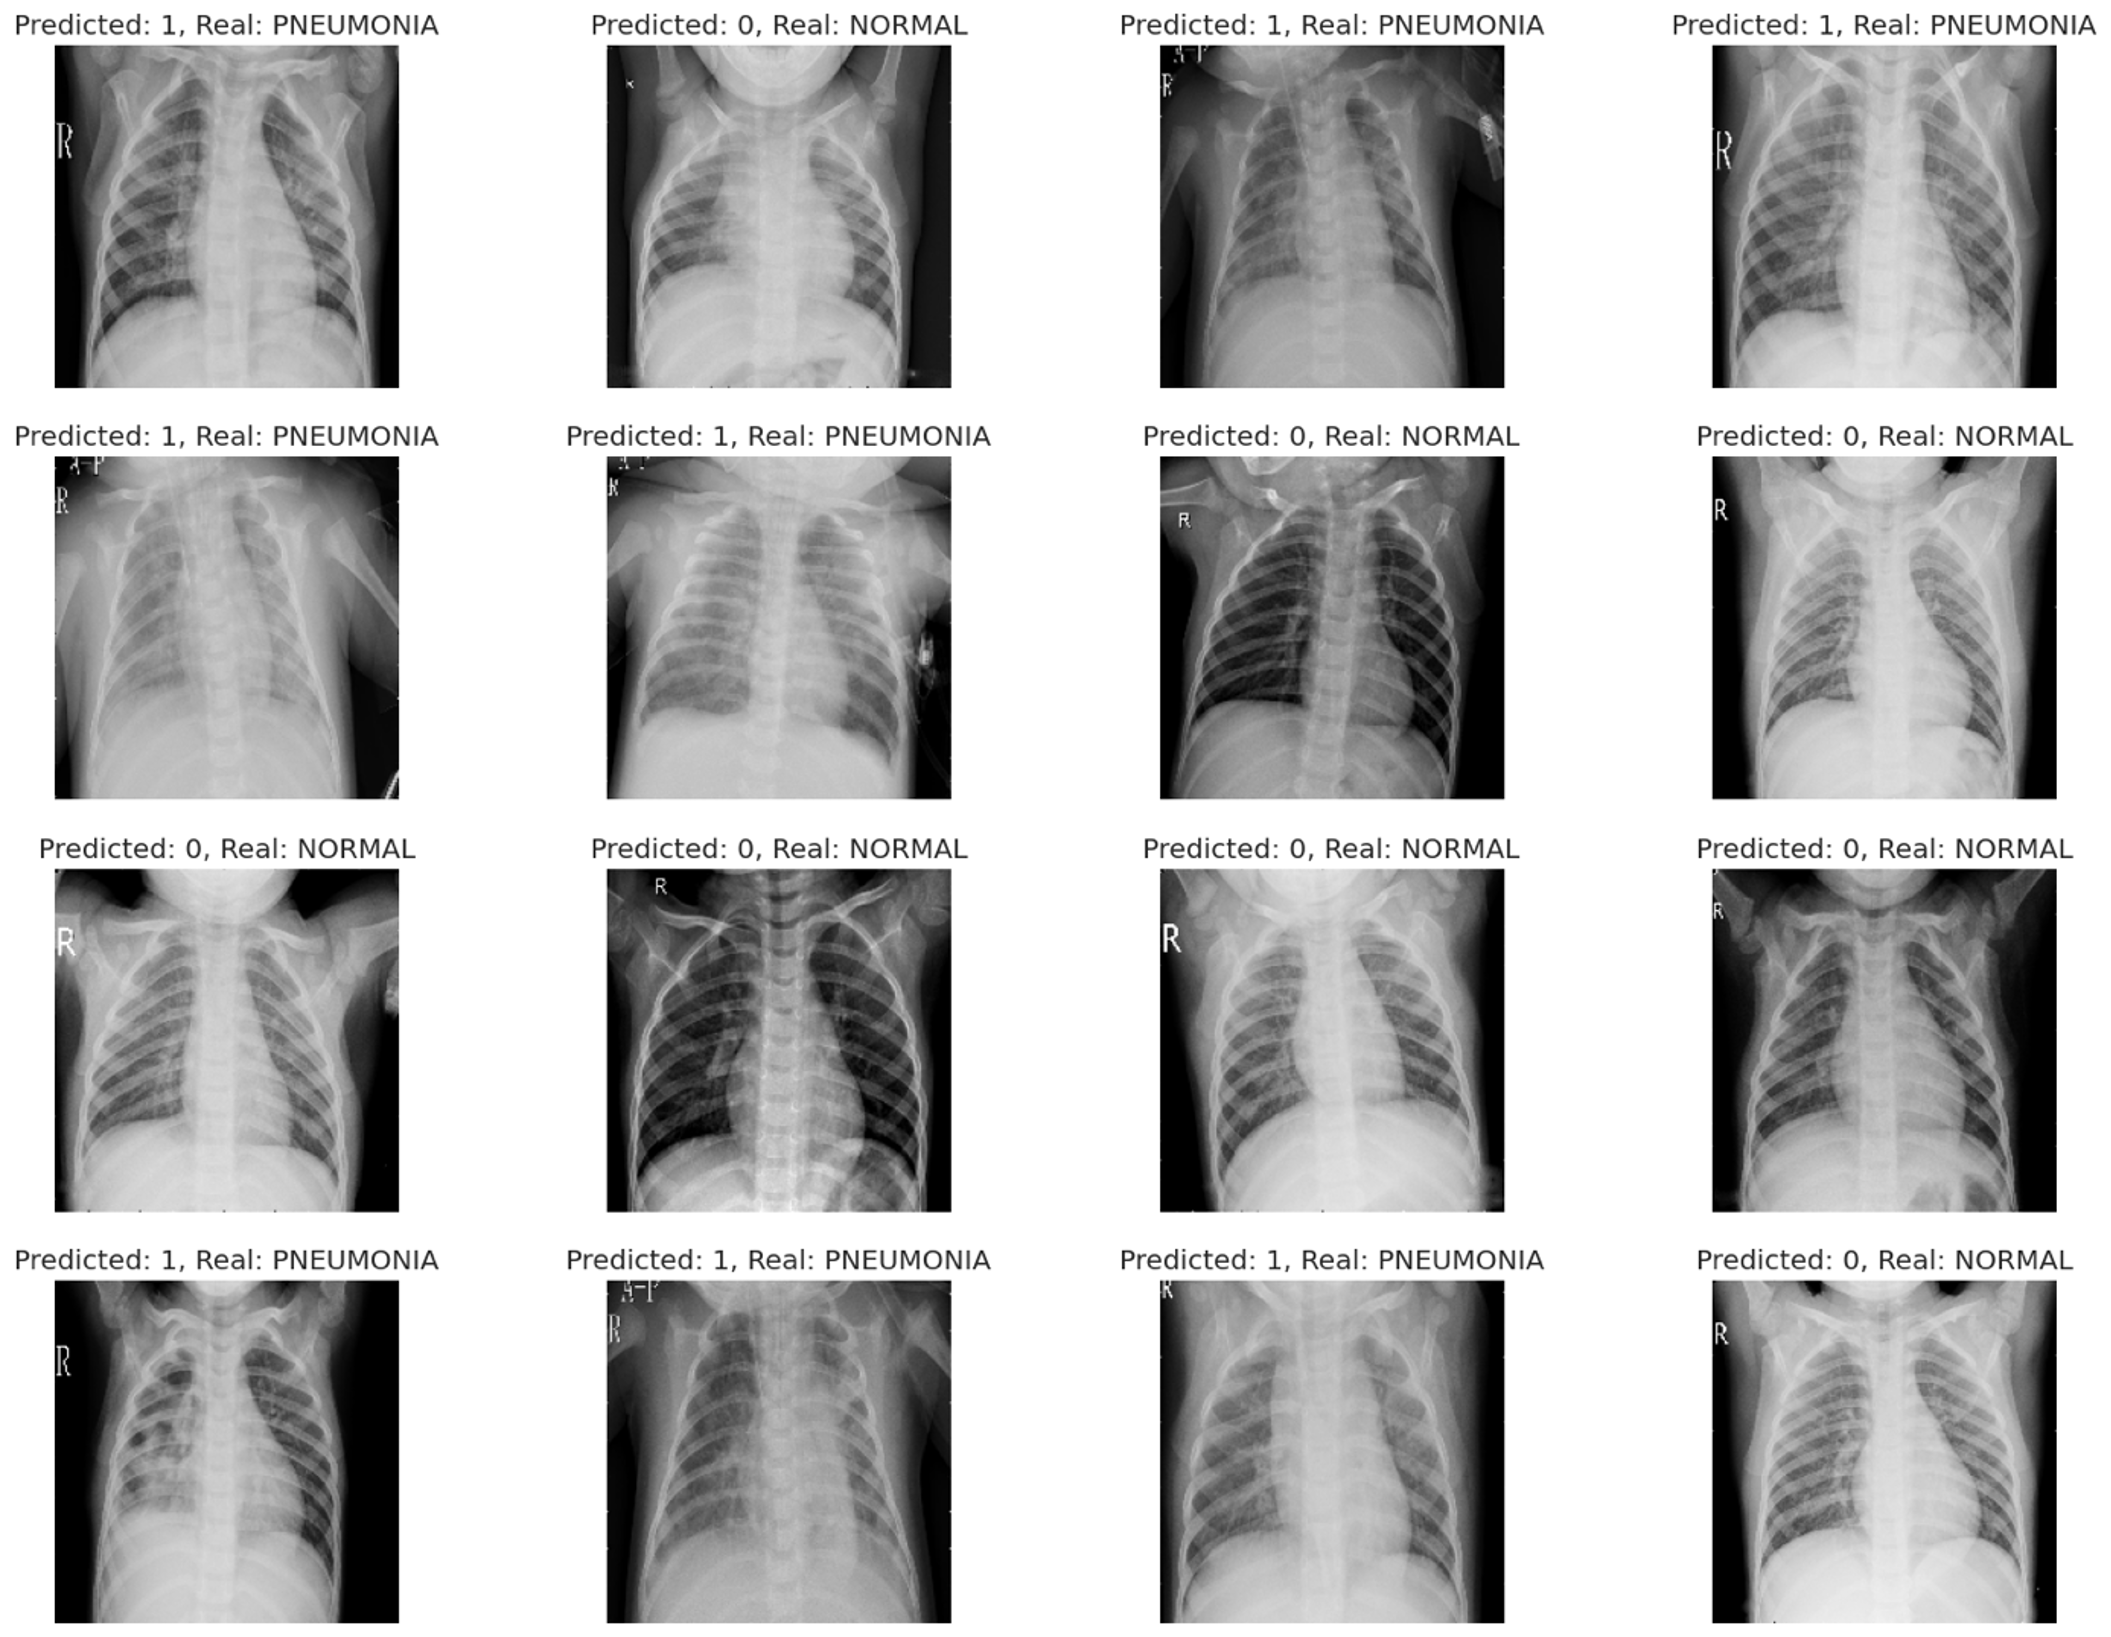

<h2> Conlusion </h2>

The result idicate that the SECOND model achieved the best performance and the loos and accuracy was the best.
From this, we can conclude that, in this particular case, having a smaller number of filters and a smaller vaue for the dense layer resulted in better outcomes.
This observation is important as it suggests that a simpler model strucute can be sufficient to achieve good results in the given task.

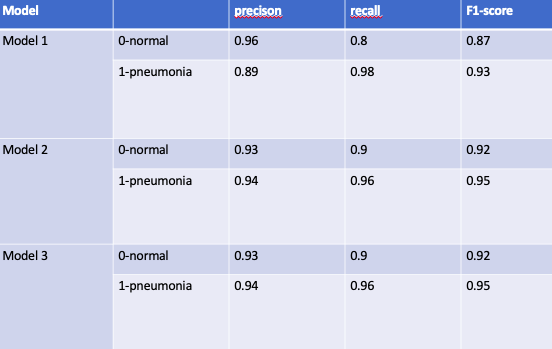